In [2]:
!pip install -q pandas seaborn scikit-plot scikit-image wandb torch-summary plotly umap-learn dotmap einops kornia opencv-python

In [3]:
!pip3 install -q torchvision # restart kernel

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.12.1 requires typing-extensions<4.6.0,>=3.6.6, but you have typing-extensions 4.11.0 which is incompatible.


In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import torch
from train import train_regressor

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(DEVICE)
next(arniqa.parameters()).is_cuda

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main


True

Loaded features from features/features.npy
Loaded scores from features/scores.npy
Iteration 1, loss = 0.06693391
Iteration 2, loss = 0.05198846
Iteration 3, loss = 0.05159934
Iteration 4, loss = 0.05151740
Iteration 5, loss = 0.05167371
Iteration 6, loss = 0.05143142
Iteration 7, loss = 0.05103116
Iteration 8, loss = 0.05061183
Iteration 9, loss = 0.05042974
Iteration 10, loss = 0.05055370
Iteration 11, loss = 0.05026896
Iteration 12, loss = 0.05007755
Iteration 13, loss = 0.04983864
Iteration 14, loss = 0.04995046
Iteration 15, loss = 0.04985759
Iteration 16, loss = 0.04951299
Iteration 17, loss = 0.04921485
Iteration 18, loss = 0.04869889
Iteration 19, loss = 0.04895062
Iteration 20, loss = 0.04878353
Iteration 21, loss = 0.04845780
Iteration 22, loss = 0.04805734
Iteration 23, loss = 0.04776118
Iteration 24, loss = 0.04777701
Iteration 25, loss = 0.04743220
Iteration 26, loss = 0.04689137
Iteration 27, loss = 0.04666993
Iteration 28, loss = 0.04683202
Iteration 29, loss = 0.04614840

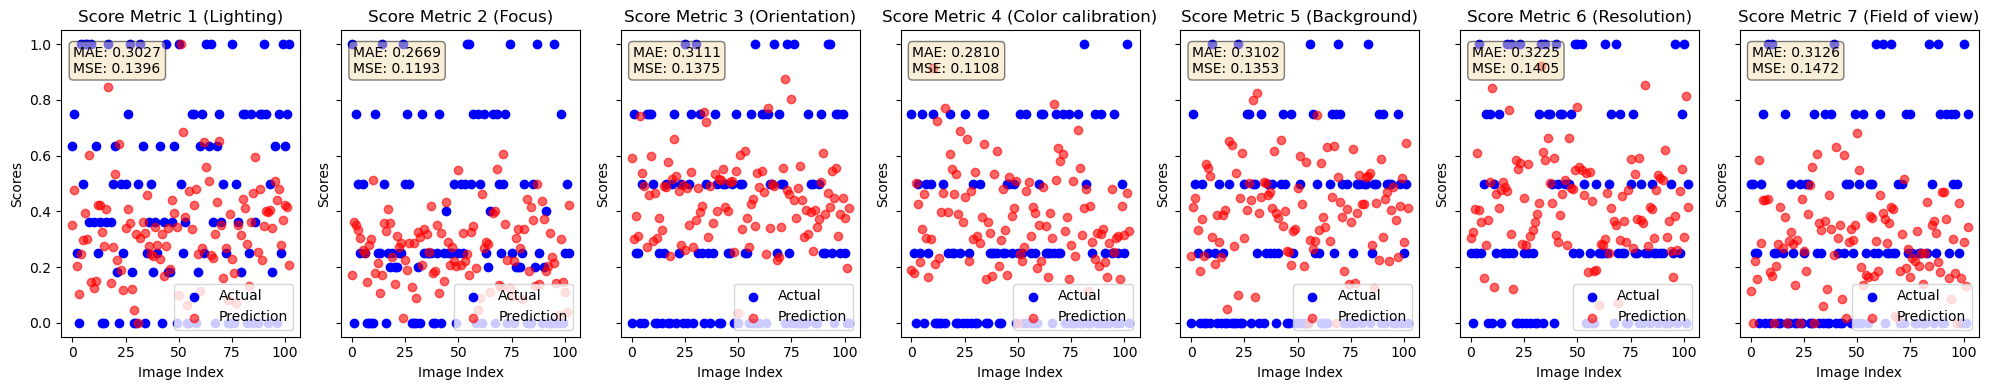

In [4]:
regressor = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='features', cross_val=False)

In [5]:
import pickle

with open("regressor.pkl", "wb") as f:
    pickle.dump(regressor, f)

Loaded features from features_test/features.npy
Loaded scores from features_test/scores.npy

MAE             MSE             SROCC           PLCC           
0.2678          0.1142          0.0577          0.0558         

Metric-by-Metric Pearson Correlations: [-0.0826, -0.0289, 0.0074, 0.0448, -0.1016, -0.0424, 0.0498]
Metric-by-Metric Spearman Correlations: [-0.0815, -0.0202, -0.039, 0.0361, -0.1375, -0.0199, 0.0482] 



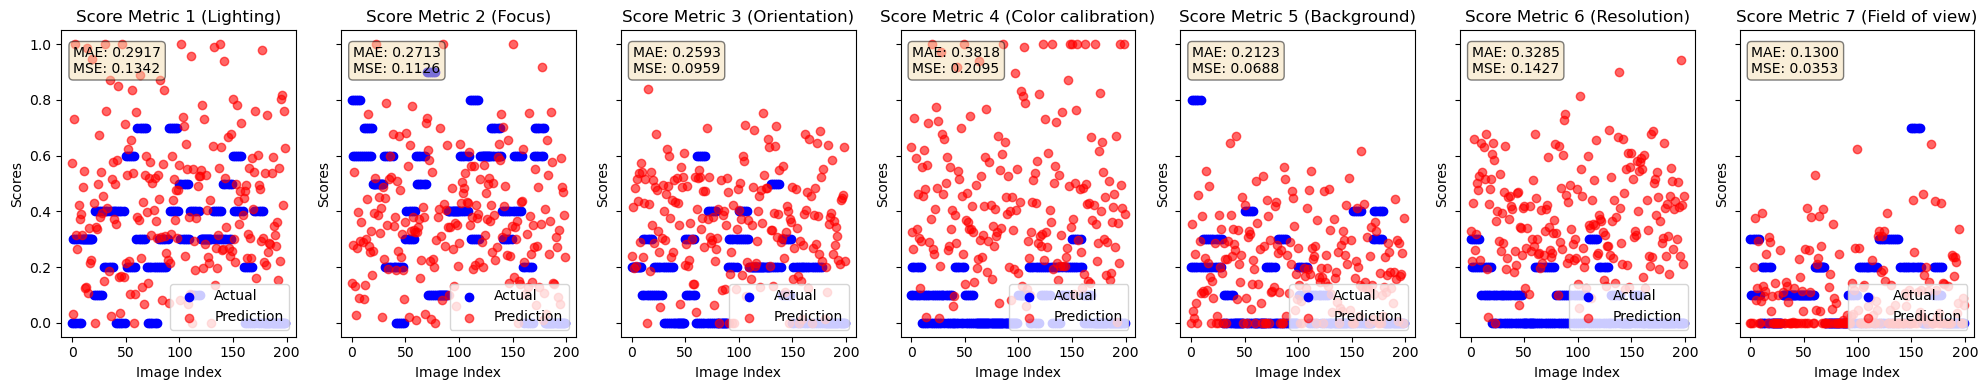

In [6]:
from test import test
test('to_label', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='features_test', regressor=regressor)

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main


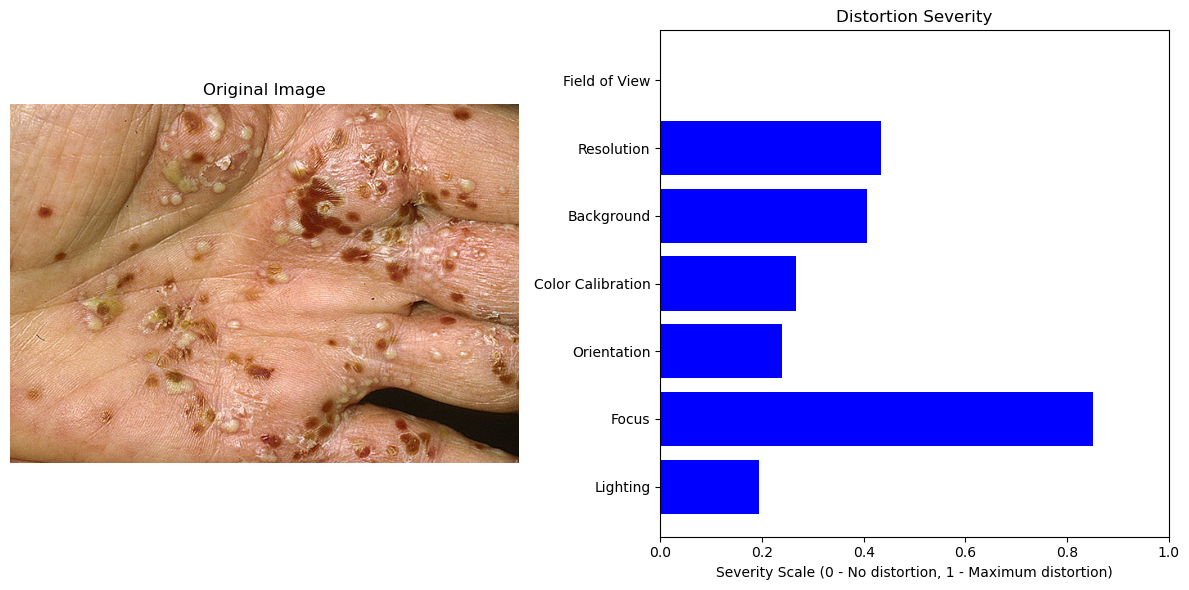

In [7]:
import torch
import pickle
from single_image_inference import single_image_inference

image_path = "2.png"

arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval()

with open("regressor.pkl", "rb") as f:
    regressor = pickle.load(f)

single_image_inference(image_path, arniqa, regressor)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Saved features to features/features.npy
Saved scores to features/scores.npy
Iteration 1, loss = 0.06625480
Iteration 2, loss = 0.05340178
Iteration 3, loss = 0.05270210
Iteration 4, loss = 0.05228246
Iteration 5, loss = 0.05261051
Iteration 6, loss = 0.05209747
Iteration 7, loss = 0.05157261
Iteration 8, loss = 0.05144019
Iteration 9, loss = 0.05155736
Iteration 10, loss = 0.05104308
Iteration 11, loss = 0.05085137
Iteration 12, loss = 0.05072449
Iteration 13, loss = 0.05042958
Iteration 14, loss = 0.04985903
Iteration 15, loss = 0.04965531
Iteration 16, loss = 0.04933766
Iteration 17, loss = 0.04950131
Iteration 18, loss = 0.04899087
Iteration 19, loss = 0.04839886
Iteration 20, loss = 0.04880327
Iteration 21, loss = 0.04774822
Iteration 22, loss = 0.04712883
Iteration 23, loss = 0.04641216
Iteration 24, loss = 0.04590331
Iteration 25, loss = 0.04564992
Iteration 26, loss = 0.04561125
Iteration 27, loss = 0.04481740
Iteration 28, loss = 0.04359565
Iteration 29, loss = 0.04291570
Itera

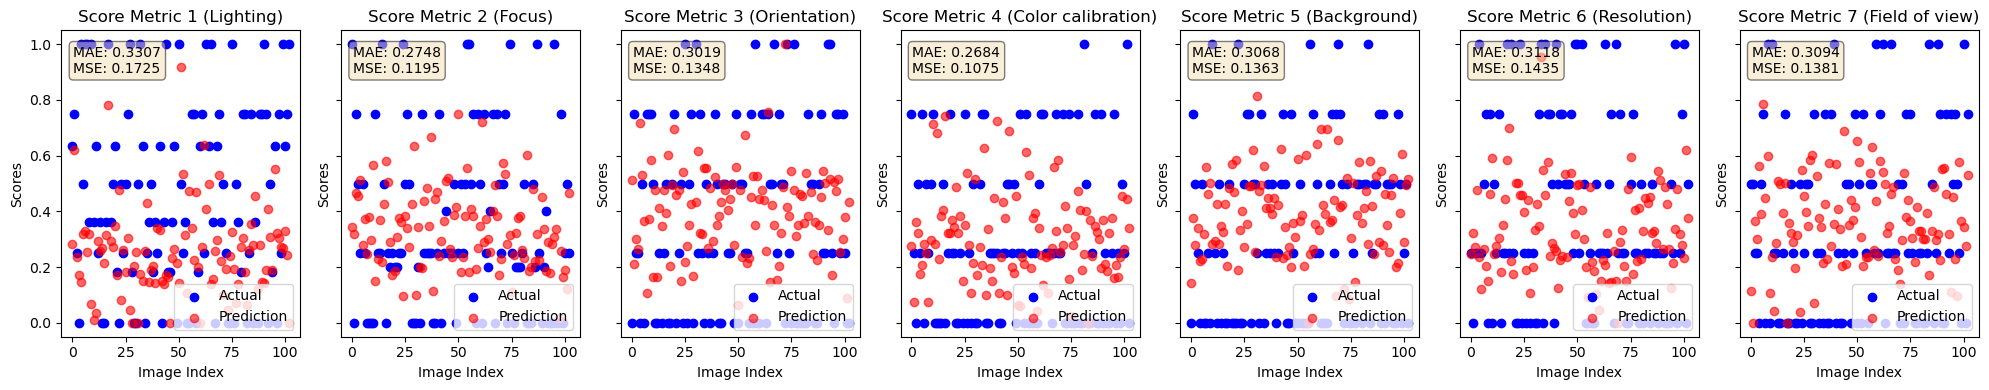

In [5]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='features', cross_val=False)

Loaded features from features/features.npy
Loaded scores from features/scores.npy
Iteration 1, loss = 0.06735498
Iteration 2, loss = 0.05395745
Iteration 3, loss = 0.05324771
Iteration 4, loss = 0.05276784
Iteration 5, loss = 0.05317382
Iteration 6, loss = 0.05271036
Iteration 7, loss = 0.05216054
Iteration 8, loss = 0.05194074
Iteration 9, loss = 0.05210279
Iteration 10, loss = 0.05150008
Iteration 11, loss = 0.05123836
Iteration 12, loss = 0.05128846
Iteration 13, loss = 0.05090467
Iteration 14, loss = 0.05043689
Iteration 15, loss = 0.05021712
Iteration 16, loss = 0.04967206
Iteration 17, loss = 0.04997879
Iteration 18, loss = 0.04959723
Iteration 19, loss = 0.04891529
Iteration 20, loss = 0.04928528
Iteration 21, loss = 0.04815763
Iteration 22, loss = 0.04703467
Iteration 23, loss = 0.04668097
Iteration 24, loss = 0.04559828
Iteration 25, loss = 0.04590235
Iteration 26, loss = 0.04585759
Iteration 27, loss = 0.04468116
Iteration 28, loss = 0.04419283
Iteration 29, loss = 0.04396132

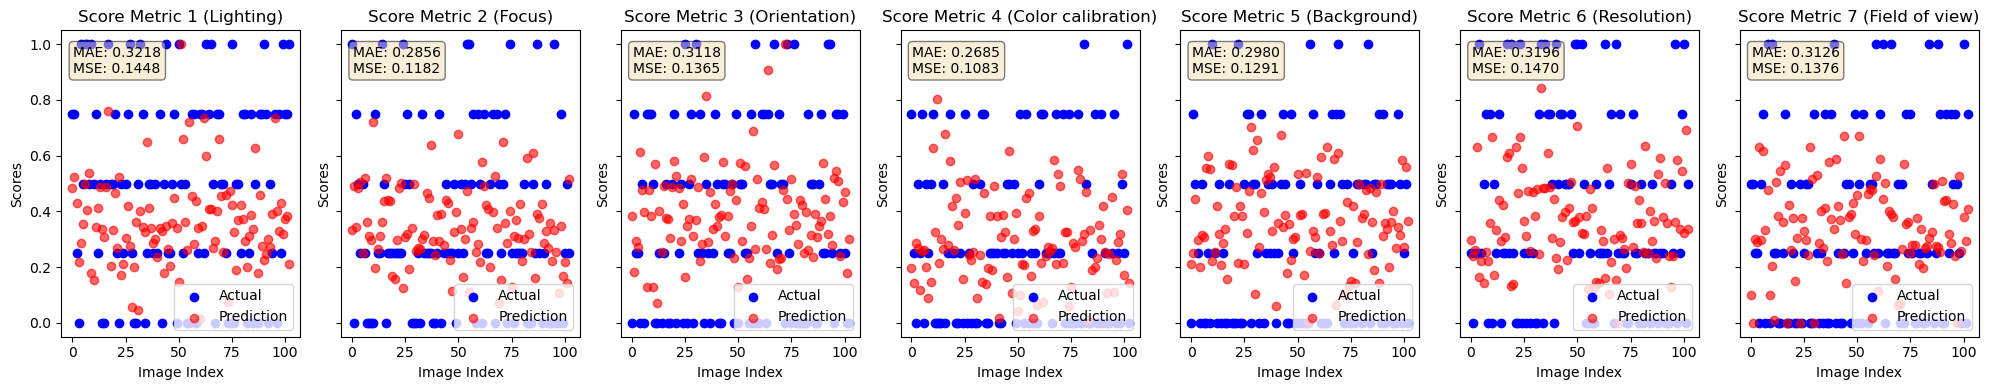

In [3]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='features', cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Saved features to features/features.npy
Saved scores to features/scores.npy
Iteration 1, loss = 0.06617245
Iteration 2, loss = 0.05492380
Iteration 3, loss = 0.05392456
Iteration 4, loss = 0.05342560
Iteration 5, loss = 0.05345417
Iteration 6, loss = 0.05323963
Iteration 7, loss = 0.05278476
Iteration 8, loss = 0.05268721
Iteration 9, loss = 0.05256819
Iteration 10, loss = 0.05223362
Iteration 11, loss = 0.05224012
Iteration 12, loss = 0.05216167
Iteration 13, loss = 0.05144135
Iteration 14, loss = 0.05148773
Iteration 15, loss = 0.05078523
Iteration 16, loss = 0.05045851
Iteration 17, loss = 0.05017711
Iteration 18, loss = 0.04981836
Iteration 19, loss = 0.04949803
Iteration 20, loss = 0.04913471
Iteration 21, loss = 0.04920752
Iteration 22, loss = 0.04892033
Iteration 23, loss = 0.04894520
Iteration 24, loss = 0.04764682
Iteration 25, loss = 0.04698713
Iteration 26, loss = 0.04673841
Iteration 27, loss = 0.04600477
Iteration 28, loss = 0.04543700
Iteration 29, loss = 0.04467132
Itera

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error: [0.3006454216565417, 0.32725260214272767, 0.2844667446031715, 0.33265287076675226, 0.29886441086078874, 0.29350423192367203, 0.28709530984739196]
Mean Squared Error: [0.14484769074924284, 0.14927225312777342, 0.12162834885653794, 0.16237154451609967, 0.12410054198228232, 0.13490977626425102, 0.11350061112981968]


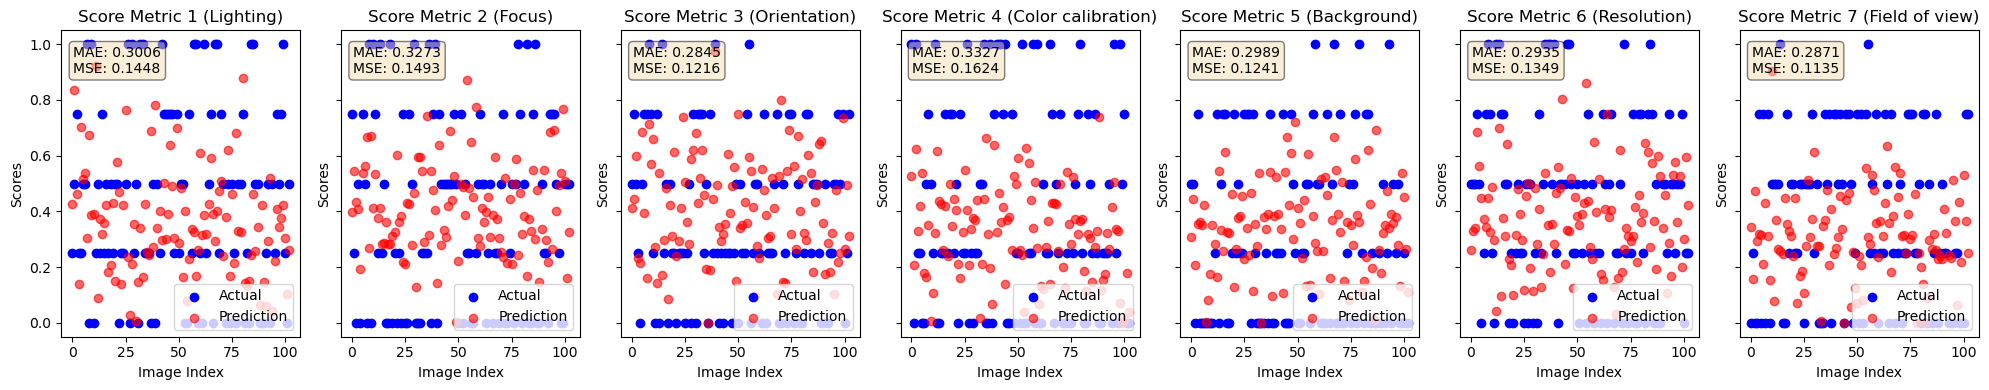

In [4]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='features', cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Iteration 1, loss = 0.06657039
Iteration 2, loss = 0.05401584
Iteration 3, loss = 0.05331503
Iteration 4, loss = 0.05300803
Iteration 5, loss = 0.05238257
Iteration 6, loss = 0.05247919
Iteration 7, loss = 0.05192863
Iteration 8, loss = 0.05189192
Iteration 9, loss = 0.05187756
Iteration 10, loss = 0.05139066
Iteration 11, loss = 0.05108844
Iteration 12, loss = 0.05093195
Iteration 13, loss = 0.05070470
Iteration 14, loss = 0.05041279
Iteration 15, loss = 0.05044471
Iteration 16, loss = 0.05012384
Iteration 17, loss = 0.04987273
Iteration 18, loss = 0.04959016
Iteration 19, loss = 0.04910951
Iteration 20, loss = 0.04854743
Iteration 21, loss = 0.04833697
Iteration 22, loss = 0.04796385
Iteration 23, loss = 0.04791937
Iteration 24, loss = 0.04736466
Iteration 25, loss = 0.04754494
Iteration 26, loss = 0.04679428
Iteration 27, loss = 0.04654790
Iteration 28, loss = 0.04636284
Iteration 29, loss = 0.04606190
Iteration 30, loss = 0.04580237
Iteration 31, loss = 0.04583315
Iteration 32, los

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(


Mean Absolute Error: [0.2937028611837109, 0.3250801200543526, 0.2616888819864737, 0.34519083507839715, 0.3241710093173082, 0.29907774276797855, 0.2711732684078013]
Mean Squared Error: [0.14297489564256569, 0.1404538165382898, 0.10412290830353306, 0.16558744558399155, 0.13718492924207204, 0.1391215730441264, 0.10112704830663292]


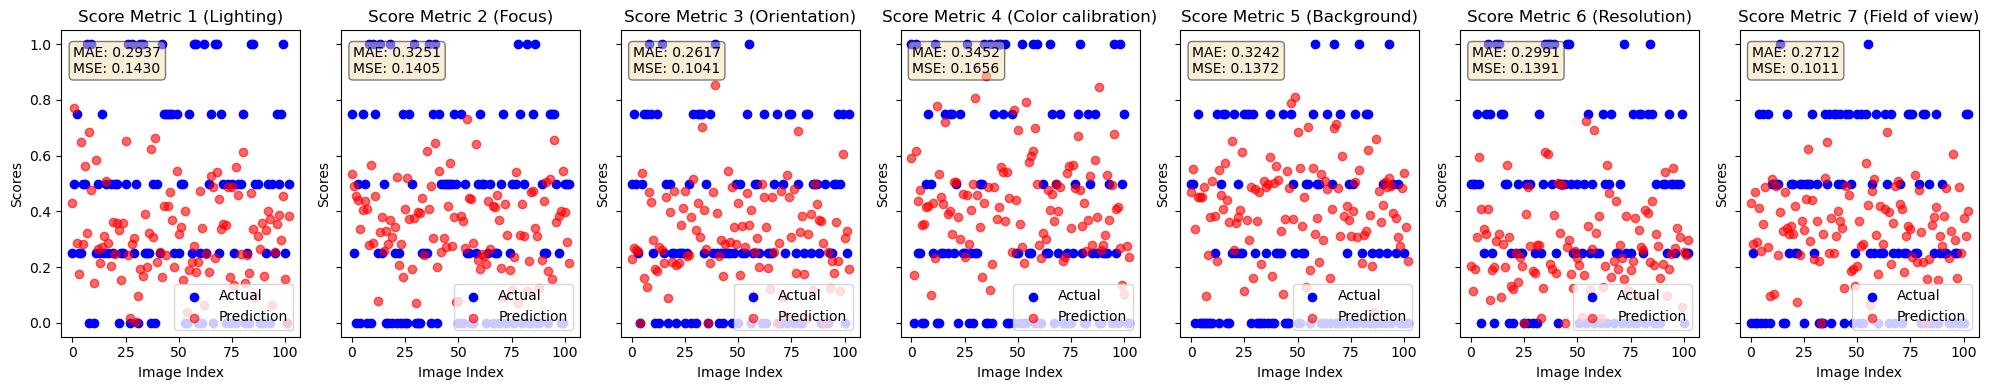

In [4]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='features', cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Iteration 1, loss = 2.06782991
Iteration 2, loss = 0.35524762
Iteration 3, loss = 0.17824579
Iteration 4, loss = 0.10677079
Iteration 5, loss = 0.07767871
Iteration 6, loss = 0.06043768
Iteration 7, loss = 0.05149454
Iteration 8, loss = 0.04322908
Iteration 9, loss = 0.03749771
Iteration 10, loss = 0.03466833
Iteration 11, loss = 0.03209139
Iteration 12, loss = 0.02981081
Iteration 13, loss = 0.02733728
Iteration 14, loss = 0.02517457
Iteration 15, loss = 0.02364667
Iteration 16, loss = 0.02211913
Iteration 17, loss = 0.02247462
Iteration 18, loss = 0.02202696
Iteration 19, loss = 0.02087597
Iteration 20, loss = 0.01880633
Iteration 21, loss = 0.01790961
Iteration 22, loss = 0.01656917
Iteration 23, loss = 0.01561333
Iteration 24, loss = 0.01492390
Iteration 25, loss = 0.01501519
Iteration 26, loss = 0.01446399
Iteration 27, loss = 0.01441034
Iteration 28, loss = 0.01515683
Iteration 29, loss = 0.01514379
Iteration 30, loss = 0.01384564
Iteration 31, loss = 0.01304562
Iteration 32, los

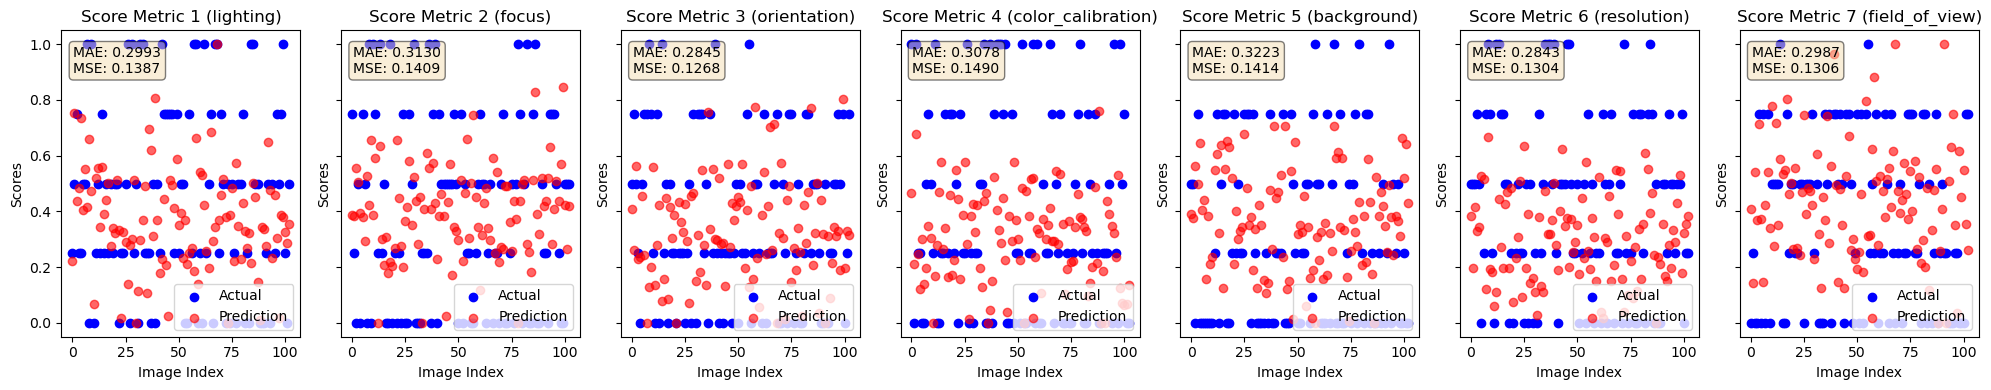

In [3]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, save_dir='scin', cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Iteration 1, loss = 0.06180384
Iteration 2, loss = 0.05294359
Iteration 3, loss = 0.05261361
Iteration 4, loss = 0.05221607
Iteration 5, loss = 0.05191974
Iteration 6, loss = 0.05180269
Iteration 7, loss = 0.05176535
Iteration 8, loss = 0.05122589
Iteration 9, loss = 0.05107086
Iteration 10, loss = 0.05097748
Iteration 11, loss = 0.05086212
Iteration 12, loss = 0.05074992
Iteration 13, loss = 0.05040368
Iteration 14, loss = 0.05041975
Iteration 15, loss = 0.05021925
Iteration 16, loss = 0.04967106
Iteration 17, loss = 0.04970234
Iteration 18, loss = 0.04956143
Iteration 19, loss = 0.04946291
Iteration 20, loss = 0.04908447
Iteration 21, loss = 0.04890942
Iteration 22, loss = 0.04852149
Iteration 23, loss = 0.04841737
Iteration 24, loss = 0.04863564
Iteration 25, loss = 0.04810177
Iteration 26, loss = 0.04762665
Iteration 27, loss = 0.04752124
Iteration 28, loss = 0.04748374
Iteration 29, loss = 0.04681470
Iteration 30, loss = 0.04651127
Iteration 31, loss = 0.04662508
Iteration 32, los

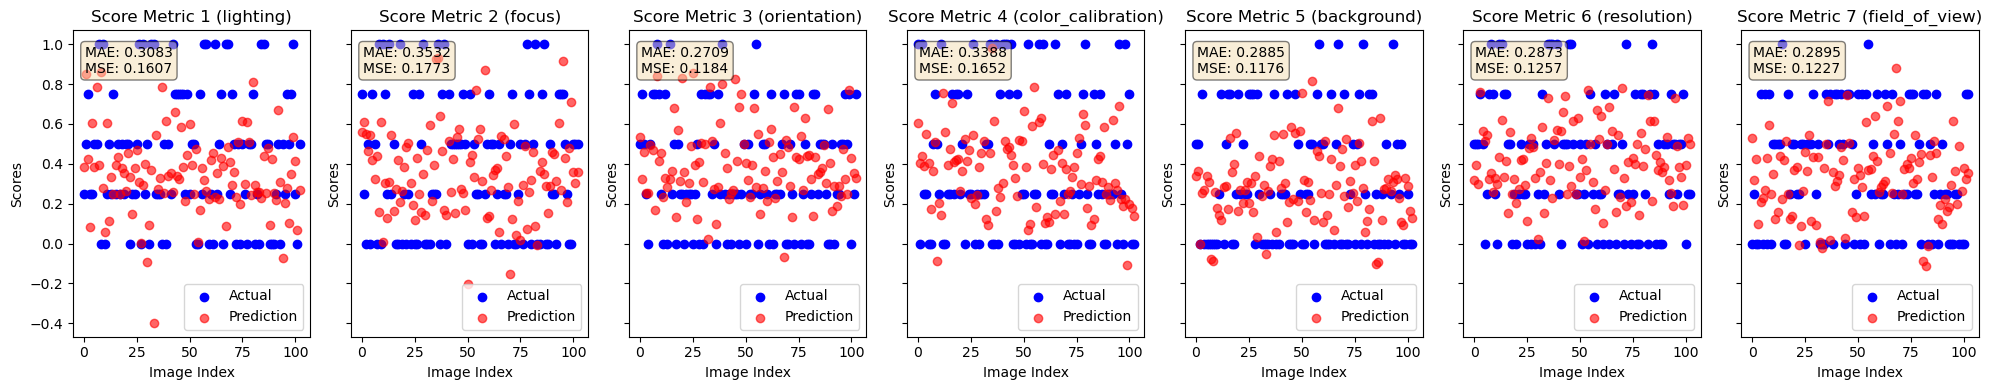

In [3]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Iteration 1, loss = 0.06878966
Iteration 2, loss = 0.05381822
Iteration 3, loss = 0.05246152
Iteration 4, loss = 0.05203852
Iteration 5, loss = 0.05202968
Iteration 6, loss = 0.05187453
Iteration 7, loss = 0.05175591
Iteration 8, loss = 0.05148856
Iteration 9, loss = 0.05137900
Iteration 10, loss = 0.05106435
Iteration 11, loss = 0.05098853
Iteration 12, loss = 0.05094387
Iteration 13, loss = 0.05075506
Iteration 14, loss = 0.05056569
Iteration 15, loss = 0.05052727
Iteration 16, loss = 0.05025492
Iteration 17, loss = 0.05039800
Iteration 18, loss = 0.05019254
Iteration 19, loss = 0.04994817
Iteration 20, loss = 0.04984838
Iteration 21, loss = 0.04960744
Iteration 22, loss = 0.04954239
Iteration 23, loss = 0.04943937
Iteration 24, loss = 0.04914146
Iteration 25, loss = 0.04897328
Iteration 26, loss = 0.04881081
Iteration 27, loss = 0.04864001
Iteration 28, loss = 0.04828452
Iteration 29, loss = 0.04819106
Iteration 30, loss = 0.04799044
Iteration 31, loss = 0.04768245
Iteration 32, los

/opt/conda/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


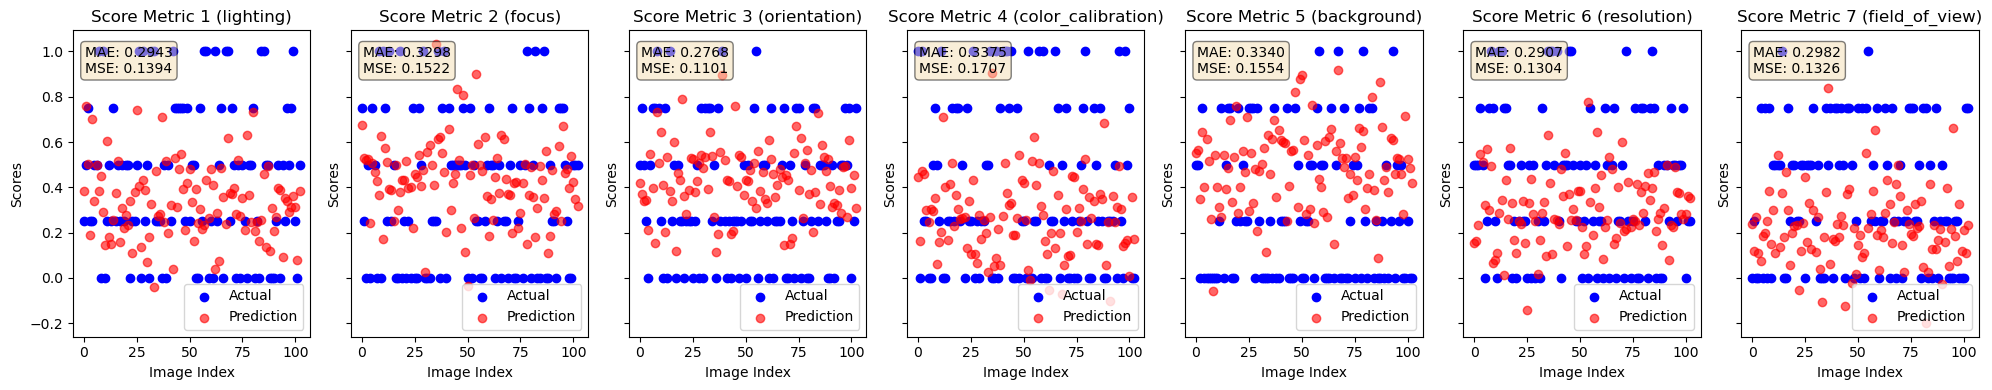

In [3]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


      Iter       Train Loss   Remaining Time 
         1           0.0568            2.16m
         2           0.0551            2.10m
         3           0.0535            2.07m
         4           0.0516            2.02m
         5           0.0506            1.97m
         6           0.0496            1.92m
         7           0.0488            1.88m
         8           0.0480            1.84m
         9           0.0476            1.80m
        10           0.0470            1.76m
        20           0.0417            1.32m
        30           0.0380           52.53s
        40           0.0348           26.33s
        50           0.0326            0.00s
      Iter       Train Loss   Remaining Time 
         1           0.0576            2.13m
         2           0.0563            2.10m
         3           0.0548            2.05m
         4           0.0539            2.02m
         5           0.0531            1.98m
         6           0.0522            1.94m
        

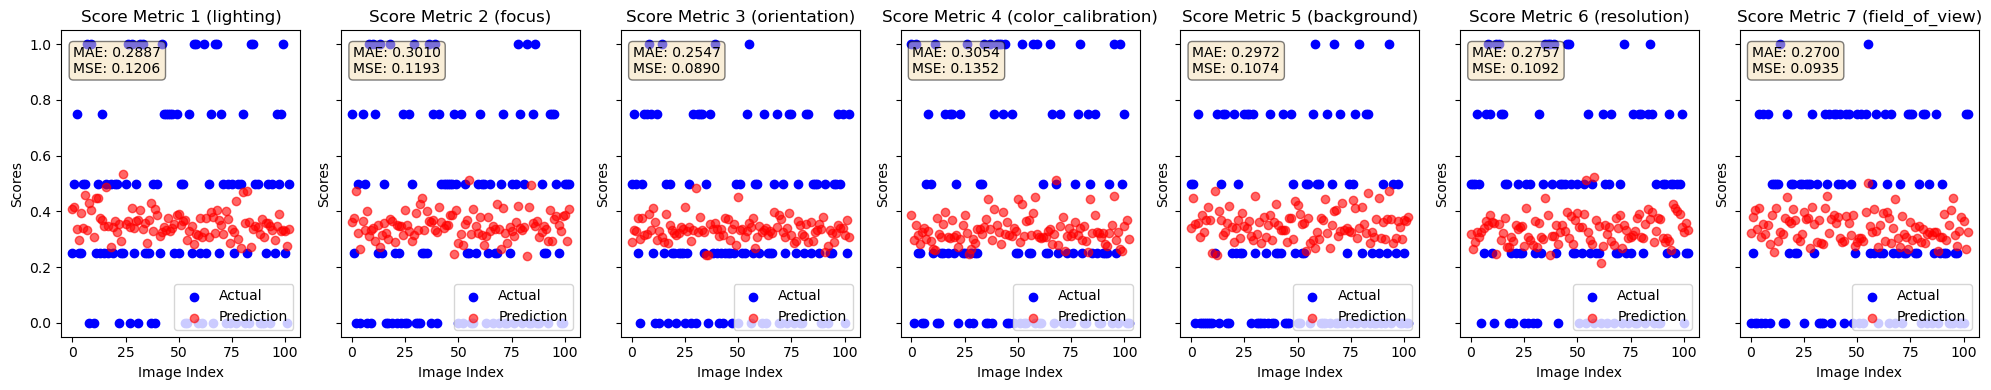

In [3]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Mean Absolute Error: [0.29075363419835965, 0.30217388165888154, 0.3254518970255686, 0.2975287495868438, 0.32476912503747646, 0.2795329077619896, 0.3037062783554029]
Mean Squared Error: [0.12803198418419262, 0.13238350181640748, 0.1452196176168718, 0.12291925927038372, 0.14634909585278005, 0.1232517039210275, 0.13290333979586533]


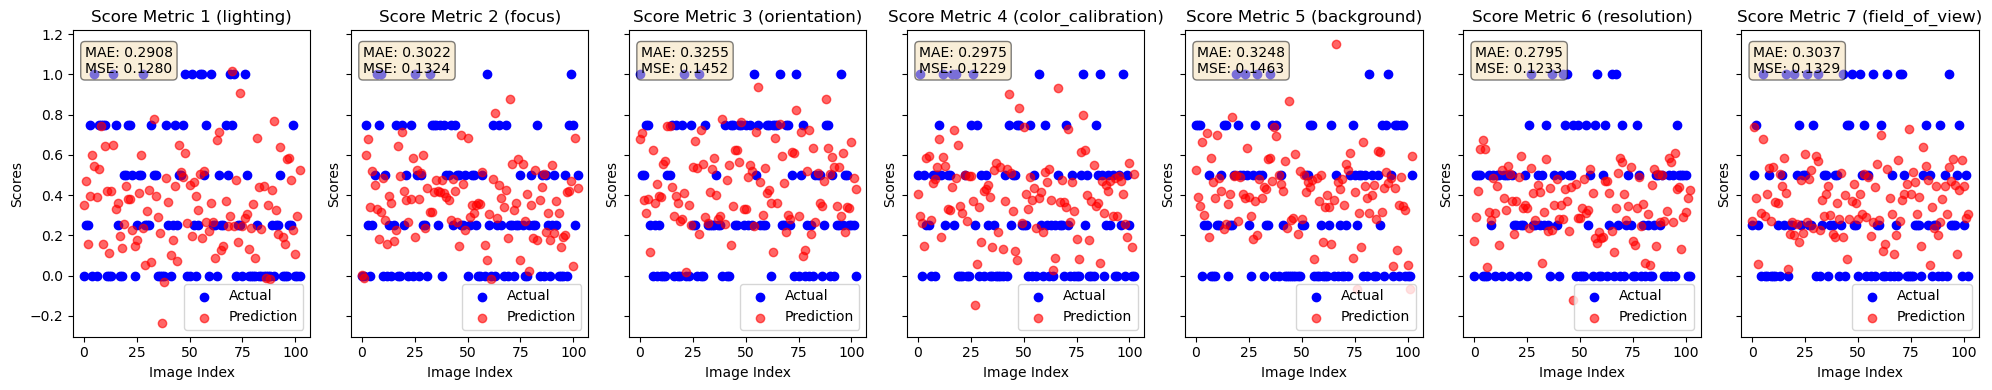

In [6]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, cross_val=False)

Extracting features:   0%|          | 0/41 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Mean Absolute Error: [0.28766851980274316, 0.2651617776236708, 0.25367876651396065, 0.2649636615811373, 0.29420169972961235, 0.2806939975342888, 0.2701920690959525]
Mean Squared Error: [0.1156859056557901, 0.09593356555490842, 0.08575691832864087, 0.09152818656227413, 0.119311498455985, 0.10638337681636773, 0.09809217797686341]


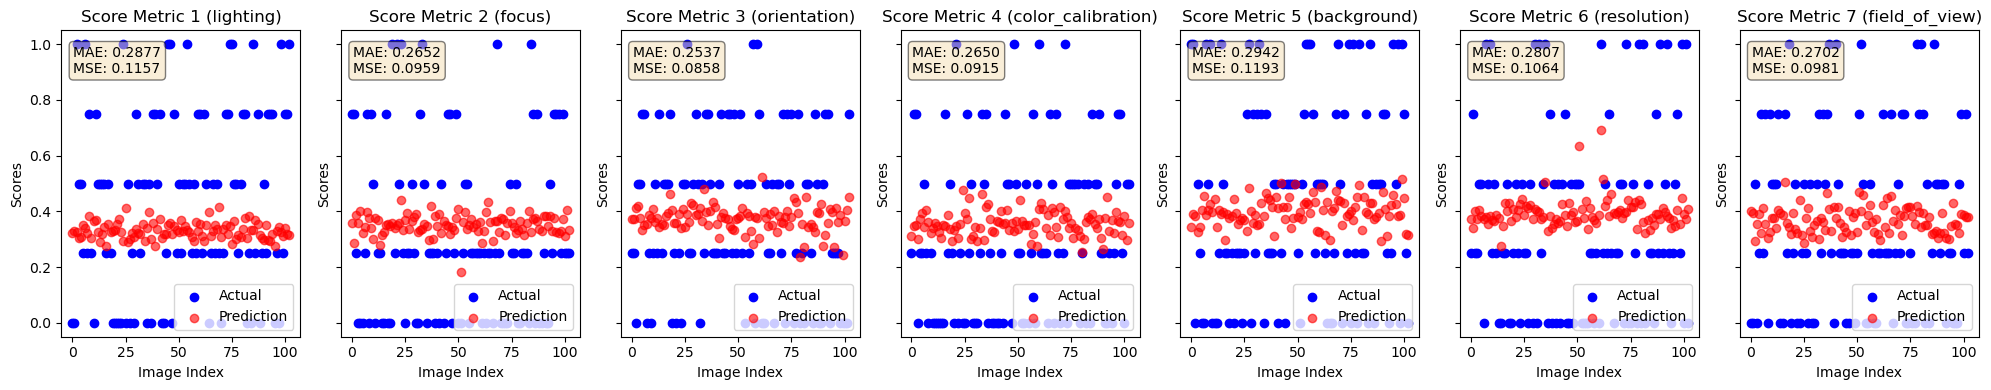

In [20]:
regressor, val, pred = train_regressor('images', crop=True, normalize=True, batch_size=10, num_workers=1, model=arniqa, device=DEVICE, cross_val=False)

In [16]:
from scipy import stats

def calculate_correlations(predictions, actual_scores):
    pearson_correlations = []
    spearman_correlations = []
    
    # Iterate over each score metric
    for i in range(predictions.shape[1]):
        # Pearson correlation
        pearson_corr, _ = stats.pearsonr(predictions[:, i], actual_scores[:, i])
        pearson_correlations.append(pearson_corr)
        
        # Spearman correlation
        spearman_corr, _ = stats.spearmanr(predictions[:, i], actual_scores[:, i])
        spearman_correlations.append(spearman_corr)
        
        # Print the correlation values for each metric
        print(f"Metric {i+1} - Pearson Correlation: {pearson_corr:.4f}, Spearman Correlation: {spearman_corr:.4f}")
    
    return pearson_correlations, spearman_correlations

pearson_correlations, spearman_correlations = calculate_correlations(pred, val)

Metric 1 - Pearson Correlation: 0.0622, Spearman Correlation: 0.0966
Metric 2 - Pearson Correlation: -0.0904, Spearman Correlation: -0.0729
Metric 3 - Pearson Correlation: 0.0139, Spearman Correlation: -0.0428
Metric 4 - Pearson Correlation: 0.0283, Spearman Correlation: 0.0444
Metric 5 - Pearson Correlation: 0.0514, Spearman Correlation: -0.0076
Metric 6 - Pearson Correlation: -0.0130, Spearman Correlation: 0.0089
Metric 7 - Pearson Correlation: 0.0573, Spearman Correlation: 0.0539


In [21]:
print("Feature importances RandomForest:", regressor.feature_importances_)

Feature importances RandomForest: [6.38038373e-05 2.36815732e-04 2.02668096e-04 ... 2.47130484e-04
 2.97624321e-04 2.81702061e-04]


LR: 
Mean Absolute Error: 0.2177400775970633
Mean Squarred Error: 0.08733567035093213

1. **Linear Regression**:
   - **Reasons to consider**: Linear regression is simple, interpretable, and computationally efficient. It assumes a linear relationship between the features and targets, which can be suitable for datasets with linear relationships or when interpretability is important.

2. **Decision Trees**:
   - **Reasons to consider**: Decision trees are non-parametric and can capture complex relationships between features and targets. They are robust to outliers and can handle both numerical and categorical data. However, they are prone to overfitting, especially with deep trees.

3. **Random Forests**:
   - **Reasons to consider**: Random forests are an ensemble method built on top of decision trees. They improve upon decision trees by reducing overfitting through bagging and random feature selection. They are robust, perform well on a wide range of datasets, and require minimal hyperparameter tuning.

4. **Gradient Boosting Machines (GBM)**:
   - **Reasons to consider**: GBM is an ensemble method that builds trees sequentially, each one correcting the errors of its predecessor. It typically performs better than random forests but may require more computational resources and tuning. XGBoost and LightGBM are popular implementations of GBM known for their efficiency and performance.

5. **Neural Network-based Models** (e.g., MLP, CNN):
   - **Reasons to consider**: Neural network-based models can capture complex nonlinear relationships in the data. They can automatically learn hierarchical features from the input data and perform well on large datasets. However, they may require more data and computational resources for training and tuning, and they are often considered as a choice when other simpler models do not perform well.

In [1]:
from data import GQIDataset
from torch.utils.data import DataLoader

dataset = GQIDataset(root='temp', crop=True, normalize=True)
dataloader = DataLoader(dataset, batch_size=1, shuffle=True, num_workers=1, pin_memory=True)

In [2]:
# Print some sample data to confirm everything is as expected
for i, sample in enumerate(dataloader):
    print(f"Batch {i}:")
    print(f"Images Shape: {sample['img'].shape}, Type: {sample['img'].dtype}")
    print(f"Downscaled Images Shape: {sample['img_ds'].shape}, Type: {sample['img_ds'].dtype}")
    print(f"Labels: {sample['label']}")
    if i == 0:  # Just print one batch for brevity
        break

/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Batch 0:
Images Shape: torch.Size([1, 5, 3, 224, 224]), Type: torch.float32
Downscaled Images Shape: torch.Size([1, 5, 3, 224, 224]), Type: torch.float32
Labels: tensor([[0.5000, 0.7500, 0.5000, 0.0000, 0.7500, 0.0000, 1.0000]],
       dtype=torch.float16)


In [4]:
import torch
import numpy as np
from einops import rearrange

def get_features_scores(model: torch.nn.Module, dataloader: DataLoader, device: torch.device):
    feats = np.zeros((0, model.encoder.feat_dim * 2))  # Double the features
    scores = np.zeros((0, 7))  # Initialize score array assuming there are 7 scores per image
    
    for batch_index, batch in enumerate(dataloader):
        img_orig = batch["img"].to(device)
        img_ds = batch["img_ds"].to(device)
        label = batch["label"].repeat(5, 1)

        # Print initial shapes for debugging
        print(f"Batch {batch_index}: Original Image Shape: {img_orig.shape}, Downsampled Image Shape: {img_ds.shape}")
        print(f"Labels Shape After Repetition: {label.shape}")


        # Rearrange images for processing
        img_orig = rearrange(img_orig, "b n c h w -> (b n) c h w")
        img_ds = rearrange(img_ds, "b n c h w -> (b n) c h w")

        print(f"Rearranged Original Image Shape: {img_orig.shape}, Rearranged Downsampled Image Shape: {img_ds.shape}")

        with torch.cuda.amp.autocast(), torch.no_grad():
            _, f = model(img_orig, img_ds, return_embedding=True)  # Get features

        feats = np.concatenate((feats, f.cpu().numpy()), 0)
        scores = np.concatenate((scores, label.numpy()), 0)

        print(f"Updated Features Shape: {feats.shape}, Updated Scores Shape: {scores.shape}")

    return feats, scores

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(DEVICE)
next(arniqa.parameters()).is_cuda
features, scores = get_features_scores(arniqa, dataloader, DEVICE)

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main
/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)


Batch 0: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: torch.Size([5, 3, 224, 224]), Rearranged Downsampled Image Shape: torch.Size([5, 3, 224, 224])
Updated Features Shape: (5, 4096), Updated Scores Shape: (5, 7)
Batch 1: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: torch.Size([5, 3, 224, 224]), Rearranged Downsampled Image Shape: torch.Size([5, 3, 224, 224])
Updated Features Shape: (10, 4096), Updated Scores Shape: (10, 7)
Batch 2: Original Image Shape: torch.Size([1, 5, 3, 224, 224]), Downsampled Image Shape: torch.Size([1, 5, 3, 224, 224])
Labels Shape After Repetition: torch.Size([5, 7])
Rearranged Original Image Shape: torch.Size([5, 3, 224, 224]), Rearranged Downsampled Image Shape: to

In [3]:
import torch
from train import get_features_scores

DEVICE = torch.device("cuda") if torch.cuda.is_available() else "cpu"
arniqa = torch.hub.load(repo_or_dir="miccunifi/ARNIQA", source="github", model="ARNIQA")
arniqa.eval().to(DEVICE)
next(arniqa.parameters()).is_cuda
features, scores = get_features_scores(arniqa, dataloader, DEVICE)

Using cache found in /home/jovyan/.cache/torch/hub/miccunifi_ARNIQA_main
Extracting features:   0%|          | 0/3 [00:00<?, ?it/s]/opt/conda/lib/python3.11/site-packages/torchvision/transforms/functional.py:690: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b_matrix = torch.tensor(startpoints, dtype=torch.float64).view(8)
/opt/conda/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split

image_indices = np.arange(len(dataset))
print(f"Total images: {len(image_indices)}")

train_img_indices, val_img_indices = train_test_split(image_indices, test_size=0.25, random_state=42, shuffle=True)
train_indices = np.repeat(train_img_indices * 5, 5) + np.tile(np.arange(5), len(train_img_indices))
val_indices = np.repeat(val_img_indices * 5, 5) + np.tile(np.arange(5), len(val_img_indices))
print("Example Training Indices:", train_indices[:10])
print("Example Validation Indices:", val_indices[:10])

train_features = features[train_indices]
train_scores = scores[train_indices]
val_features = features[val_indices]
val_scores = scores[val_indices]
val_scores = val_scores[::5]  # Scores are repeated for each crop, so we only keep the first one
orig_val_indices = val_indices[::5] // 5  # Get original indices

print("Training Features Shape:", train_features.shape)
print("Training Scores Shape:", train_scores.shape)
print("Validation Features Shape:", val_features.shape)
print("Validation Scores Shape:", val_scores.shape)

# Optional: Detailed check to ensure all crops of a single image are in the same subset
for start in range(0, len(train_img_indices) * 5, 5):
    print(f"Training group from image {train_img_indices[start//5]} (indices {train_indices[start:start+5]}):")
    print(train_scores[start:start+5])

for start in range(0, len(val_img_indices) * 5, 5):
    print(f"Validation group from image {val_img_indices[start//5]} (indices {val_indices[start:start+5]}):")
    print(val_scores[start:start+5])

Total images: 3
Example Training Indices: [ 5  6  7  8  9 10 11 12 13 14]
Example Validation Indices: [0 1 2 3 4]
Training Features Shape: (10, 4096)
Training Scores Shape: (10, 7)
Validation Features Shape: (5, 4096)
Validation Scores Shape: (1, 7)
Training group from image 1 (indices [5 6 7 8 9]):
[[1.   0.25 0.   0.25 0.75 0.   0.  ]
 [1.   0.25 0.   0.25 0.75 0.   0.  ]
 [1.   0.25 0.   0.25 0.75 0.   0.  ]
 [1.   0.25 0.   0.25 0.75 0.   0.  ]
 [1.   0.25 0.   0.25 0.75 0.   0.  ]]
Training group from image 2 (indices [10 11 12 13 14]):
[[0.75 0.   0.75 1.   0.5  0.   0.  ]
 [0.75 0.   0.75 1.   0.5  0.   0.  ]
 [0.75 0.   0.75 1.   0.5  0.   0.  ]
 [0.75 0.   0.75 1.   0.5  0.   0.  ]
 [0.75 0.   0.75 1.   0.5  0.   0.  ]]
Validation group from image 0 (indices [0 1 2 3 4]):
[[0.5  0.25 0.25 0.75 0.25 0.25 0.5 ]]


In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

regressor = LinearRegression().fit(train_features, train_scores)

predictions = regressor.predict(val_features)
print("Predictions Shape:", predictions.shape)

predictions = np.reshape(predictions, (-1, 5, 7))  # Reshape to group crops per image
predictions = np.mean(predictions, axis=1)
print("Predictions Shape After Averaging:", predictions.shape)

print("Length of Predictions:", len(predictions))
print("Length of Validation Scores:", len(val_scores))
mae = []
mse = []

# Calculate statistics for each score metric
for i in range(predictions.shape[1]):
    mae_value = mean_absolute_error(val_scores[:, i], predictions[:, i])
    mse_value = mean_squared_error(val_scores[:, i], predictions[:, i])

    mae.append(mae_value)
    mse.append(mse_value)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)

Predictions Shape: (5, 7)
Predictions Shape After Averaging: (1, 7)
Length of Predictions: 1
Length of Validation Scores: 1
Mean Absolute Error: [0.3305132288160102, 0.1694867711839898, 0.26357250938690613, 0.013572509386906129, 0.3305132288160102, 0.25, 0.5]
Mean Squared Error: [0.10923899442238431, 0.028725765606374118, 0.06947046770451072, 0.00018421301105765497, 0.10923899442238431, 0.0625, 0.25]


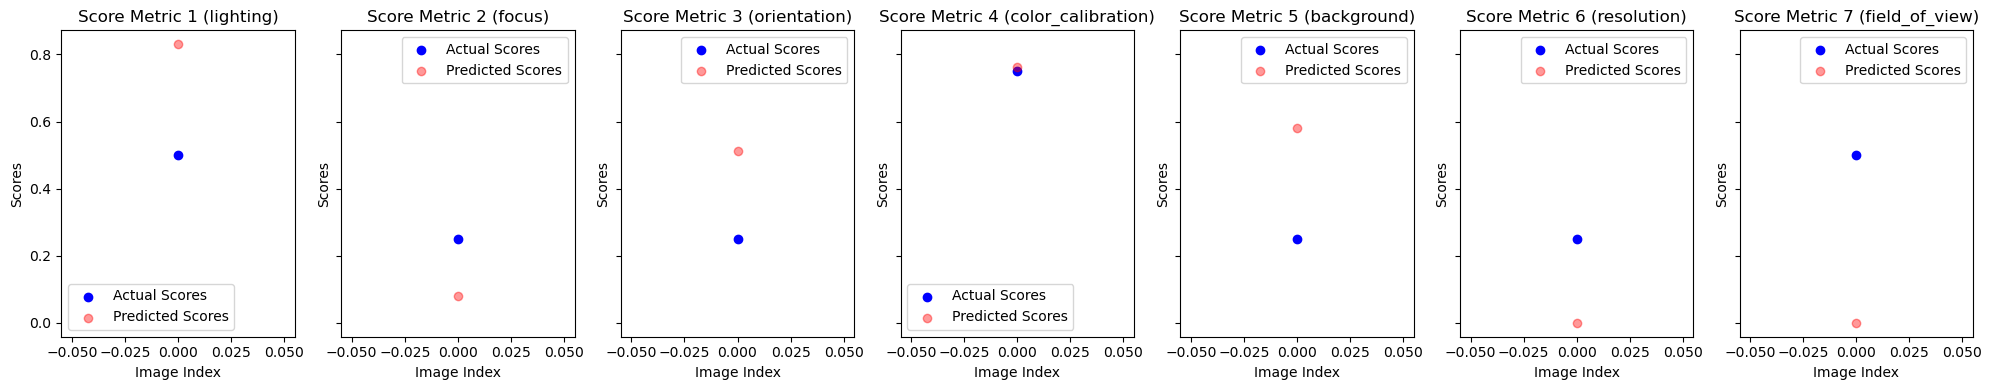

In [10]:
distortion_criteria = ["lighting", "focus", "orientation", "color_calibration", "background", "resolution", "field_of_view"]

fig, axes = plt.subplots(1, predictions.shape[1], figsize=(20, 4), sharey=True)
for i, ax in enumerate(axes):
    ax.scatter(range(len(val_scores[:, i])), val_scores[:, i], color='blue', label='Actual Scores')
    ax.scatter(range(len(predictions[:, i])), predictions[:, i], color='red', label='Predicted Scores', alpha=0.4)
    ax.set_title(f'Score Metric {i+1} ({distortion_criteria[i]})')
    ax.set_xlabel('Image Index')
    ax.set_ylabel('Scores')
    ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Load the full-scale image
#img_path = "1.jpg"
img_path = "2.png"
img = Image.open(img_path).convert("RGB")
img_ds = transforms.Resize((img.size[1] // 2, img.size[0] // 2))(img)

def display_image(image_path):
    width, height = image_path.size
    print(f"Image size: {width}x{height} pixels")
    display(image_path)
#display_image(img)

img = preprocess(img).unsqueeze(0).to(DEVICE)
img_ds = preprocess(img_ds).unsqueeze(0).to(DEVICE)

In [ ]:
with torch.no_grad(), torch.cuda.amp.autocast():
    _, features = arniqa(img, img_ds, return_embedding=True, scale_score=True)
    features = features.cpu().numpy()
predicted_score = regressor.predict(features)
print("Predicted Score:", predicted_score)

In [ ]:
1: Predicted Score: [[ 0.22506177 -0.08953812 -0.17440884  0.41439405]]
2: Predicted Score: [[ 0.20012064  0.27296238  0.36209651 -0.09519467]]

1: Predicted Score: [[0.28  0.005 0.09  0.2  ]]
2: Predicted Score: [[0.295 0.01  0.445 0.23 ]]